In [1]:
%matplotlib inline

In [2]:
# load up relevant packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso, LassoLars, Ridge, LinearRegression


# this part taken from https://github.com/mrocklin/multipolyfit/blob/master/multipolyfit/core.py
from numpy import linalg, zeros, ones, hstack, asarray
from itertools import combinations_with_replacement

def basis_vector(n, i):
    """ Return an array like [0, 0, ..., 1, ..., 0, 0]
    >>> from multipolyfit.core import basis_vector
    >>> basis_vector(3, 1)
    array([0, 1, 0])
    >>> basis_vector(5, 4)
    array([0, 0, 0, 0, 1])
    """
    x = zeros(n, dtype=int)
    x[i] = 1
    return x

def as_tall(x):
    """ Turns a row vector into a column vector """
    return x.reshape(x.shape + (1,))

def stack_x(xs, deg):

    num_covariates = xs.shape[1]
    xs = hstack((ones((xs.shape[0], 1), dtype=xs.dtype) , xs))

    generators = [basis_vector(num_covariates+1, i)
                  for i in range(num_covariates+1)]

    # All combinations of degrees
    powers = map(sum, combinations_with_replacement(generators, deg))

    # Raise data to specified degree pattern, stack in order
    A = hstack(asarray([as_tall((xs**p).prod(1)) for p in powers]))

    return A, powers

def power_selector(zi, zj, powers, beta):
    powersum = np.sum(powers[0])
    powers_desired = np.zeros(len(powers[0]), dtype=np.int)
    powers_desired[zi - 3] += 1
    powers_desired[zj - 3] += 1
    powers_desired[0] = powersum - np.sum(powers_desired)
    ith = np.array([np.all(power == powers_desired) for power in powers])
    return beta[ith]

def mk_pretty_function(beta, powers, x_keys=['', 'r0'] + ['z{0}'.format(i) for i in xrange(4, 12)],
                       min_threshold=-20):
    num_covariates = len(powers[0]) - 1
    xs = [''] + x_keys
    terms = []
    keys = []
    for ith in xrange(len(beta)):
        coef = beta[ith]
        # since z is in the range -1 to 1, you can imagine that 
        # each additional zernike requires a compensation in the
        # coefficient by another order of magnitude
        if 'x' in x_keys:
            if_coord = powers[ith][xs.index('x')] * 2
            if_coord += powers[ith][xs.index('y')] * 2
        else:
            if_coord = 0
        if np.abs(coef) < 10 ** (min_threshold - powers[ith][0] + if_coord + np.sum(powers[ith])):
            coef = 0
        power = powers[ith]
        term = '{0:.2e}'.format(coef)
        if term.count('0') == 5:
            continue
        key = ''
        for power_ith in xrange(len(power)):
            term_power = xs[power_ith]
            number_terms = power[power_ith]
            for j in xrange(number_terms):
                key += term_power
        keys.append(key)
        if len(term) > 0:
            terms.append(term)
    # print the terms
    string = ''
    for key, term in zip(keys, terms):
        string += term
        string += ' '
        string += key
        string += ' + '
    return terms, string, keys


In [3]:
donuts = pd.read_csv('/Users/cpd/Projects/WavefrontPSF/meshes/indivi_15/donuts.csv', index_col=0)

In [19]:
donuts['one_over_rzero'] = 1. / donuts['rzero']

In [36]:
rzeros = donuts['rzero'].unique()
print(rzeros)

[ 0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19
  0.2   0.21  0.22]


In [110]:
groups.get_group(group_keys[0])['e0']

0     1.004544
1     0.967633
2     1.226601
3     1.119898
4     0.901580
5     1.000711
6     0.870524
7     1.040052
8     0.867514
9     0.878174
10    0.858761
11    0.879269
12    0.969003
13    0.859511
14    1.070413
...
199985    1.098912
199986    0.934498
199987    1.035220
199988    1.055357
199989    1.012130
199990    0.899552
199991    1.095054
199992    0.951522
199993    1.099577
199994    0.949324
199995    1.022139
199996    0.895014
199997    0.988769
199998    1.075526
199999    1.006423
Name: e0, Length: 200000, dtype: float64

In [65]:
groups = donuts.groupby('one_over_rzero')
group_keys = groups.groups.keys()
agg = groups.aggregate(np.min)

In [7]:
from WavefrontPSF.donutengine import Zernike_to_Pixel_Interpolator
from WavefrontPSF.psf_evaluator import Moment_Evaluator
PSF_Drawer = Zernike_to_Pixel_Interpolator()
PSF_Evaluator = Moment_Evaluator()
def evaluate_psf(data):
    stamps, data = PSF_Drawer(data)
    evaluated_psfs = PSF_Evaluator(stamps)
    # this is sick:
    combined_df = evaluated_psfs.combine_first(data)

    return combined_df

In [8]:
Nsample = 1000
data = {'rzero': np.random.random(Nsample) * (0.22 - 0.08) + 0.08,
        'x': np.zeros(Nsample),
        'y': np.zeros(Nsample)}
df_rzero = evaluate_psf(pd.DataFrame(data))

In [73]:
Nsample = 1000
data2 = {'rzero': np.random.random(Nsample) * (0.22 - 0.08) + 0.08,
        'x': np.zeros(Nsample) + 150,
        'y': np.zeros(Nsample) + 150}
df_rzero2 = evaluate_psf(pd.DataFrame(data2))

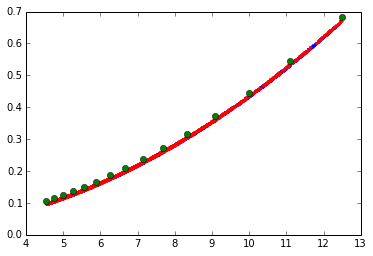

In [74]:
fig, ax = plt.subplots()
df_rzero['one_over_rzero'] = 1. / df_rzero['rzero']
df_rzero2['one_over_rzero'] = 1. / df_rzero2['rzero']
ax.plot(df_rzero['one_over_rzero'], df_rzero['e0'], 'b.')
ax.plot(df_rzero2['one_over_rzero'], df_rzero2['e0'], 'r.')
ax.plot(agg.index, agg['e0'], 'go')

In [75]:
poly3 = np.polyfit(df_rzero2['one_over_rzero'], df_rzero2['e0'], 2)
print(poly3)

[ 0.00419052  0.0010587   0.0074005 ]


[ 0.00418117  0.00106946  0.00731245]


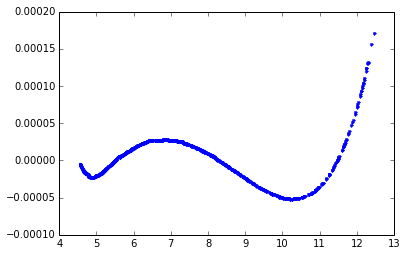

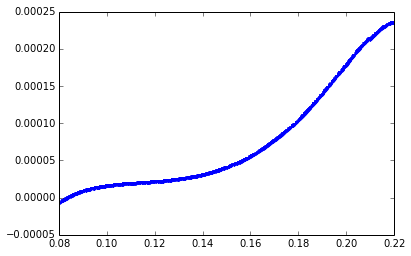

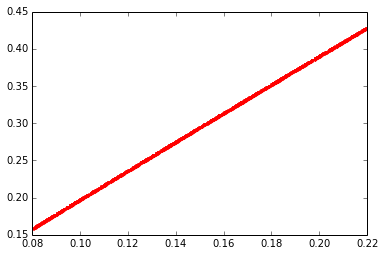

In [70]:
poly = np.polyfit(df_rzero['one_over_rzero'], df_rzero['e0'], 2)
print(poly)
plt.plot(df_rzero['one_over_rzero'], (np.polyval(poly, df_rzero['one_over_rzero']) - df_rzero['e0']), '.')
def r0_guess(e0, poly):
    a, m, b = poly
    part1 = m / (2 * e0 - b)
    part2 = part1**2 + a / (e0 - b)
    return part1 + np.sqrt(part2), part1 - np.sqrt(part2)
r0s = np.array([r0_guess(e0, poly) for e0 in df_rzero['e0']])
plt.figure()
plt.plot(df_rzero['rzero'], df_rzero['rzero'] - r0s[:,0], 'b.')
plt.figure()
plt.plot(df_rzero['rzero'], df_rzero['rzero'] - r0s[:,1], 'r.')

# ergo take the plus branch

In [106]:
# what is the smallest entry zernike wise in donuts?
duse = donuts[donuts['rzero'] == np.max(donuts['rzero'])]
zerns = duse[[key for key in donuts.keys() if key[0] == 'z' and 'zeta' not in key]].values
val = np.sqrt(np.sum(np.square(zerns), axis=1))
print(val.shape)
print(np.argmin(val))
val[np.argmin(val)]
zerns[np.argmin(val)]
print(duse.iloc[np.argmin(val)]['e0'], df_rzero['e0'].min(), duse.iloc[np.argmin(val)]['e0'] - df_rzero['e0'].min())

(200000,)
87112
0.10708618106 0.0986869545045 0.00839922655551


[ 0.00418117  0.00106946  0.00731245]
[ 0.00419052  0.0010587   0.0074005 ]
[ 0.00417719  0.00132241  0.01475661]
[ 0.99681988  1.24908199  1.99400277]
[ 0.99776758  1.01016209  0.98810208]


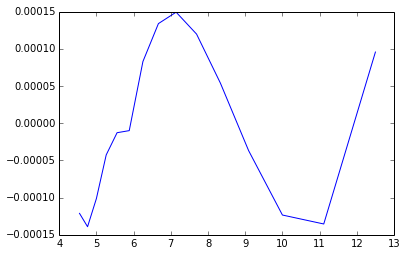

In [86]:
deg = 2
poly = np.polyfit(df_rzero['one_over_rzero'], df_rzero['e0'], deg)
print(poly)
poly3 = np.polyfit(df_rzero2['one_over_rzero'], df_rzero2['e0'], deg)
print(poly3)
poly2 = np.polyfit(agg.index, agg['e0'], deg)
print(poly2)
print(poly2 / poly3)
print(poly / poly3)
plt.plot(agg.index, (np.polyval(poly2, agg.index) - agg['e0']) / agg['e0'])

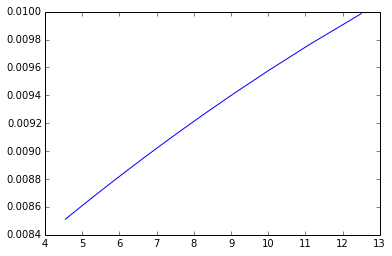

In [72]:
plt.plot(agg.index, (np.polyval(poly2, agg.index) - np.polyval(poly, agg.index)))

In [111]:
donuts.columns

Index([u'Mx', u'Mxx', u'Mxy', u'My', u'Myy', u'a4', u'delta1', u'delta2', u'e0', u'e0prime', u'e1', u'e2', u'flux', u'fwhm', u'phi', u'rzero', u'w', u'w1', u'w2', u'wd1', u'wd2', u'whisker', u'x', u'x2', u'x2y', u'x3', u'xy', u'xy2', u'y', u'y2', u'y3', u'z10', u'z11', u'z4', u'z5', u'z6', u'z7', u'z8', u'z9', u'zeta1', u'zeta2', u'one_over_rzero'], dtype='object')

In [191]:
from WavefrontPSF.analytic_interpolator import DECAM_Analytic_Wavefront
from WavefrontPSF.donutengine import DECAM_Model_Wavefront, generate_random_coordinates
rzero = 0.1401
Nsample = 1000
num_bins=2
AWF = DECAM_Analytic_Wavefront(rzero)
DWF = DECAM_Model_Wavefront()

x, y, extnum = generate_random_coordinates(Nsample)
data = pd.DataFrame({'x': x, 'y': y, 'rzero': np.ones(Nsample) * rzero})

Adf = AWF(data)
Ddf = DWF(data)

The analytic should be considerably faster...

In [192]:
%%timeit
Adf = AWF(data)

1 loops, best of 3: 428 ms per loop


In [118]:
%%timeit
Ddf = DWF(data)

1 loops, best of 3: 12.5 s per loop


In [233]:
Adf = AWF(data)
Adf['r'] = np.sqrt(Adf['x'] ** 2 + Adf['y'] ** 2)

In [238]:
# create fields
num_bins=1

AWF.data = Adf
AWF.reduce(num_bins=num_bins)
DWF.data = Ddf
DWF.reduce(num_bins=num_bins)
Diffdf = Adf.copy()
Diffdf[AWF.PSF_Evaluator.keys] = (Adf - Ddf)[AWF.PSF_Evaluator.keys]
for key in AWF.PSF_Evaluator.keys:
    Diffdf['{0}_true'.format(key)] = Ddf[key]
DiffWF = DECAM_Model_Wavefront()
DiffWF.data = Diffdf
DiffWF.reduce(num_bins=num_bins)

(<matplotlib.figure.Figure at 0x1362a42d0>,
 <matplotlib.axes.AxesSubplot at 0x132760910>)

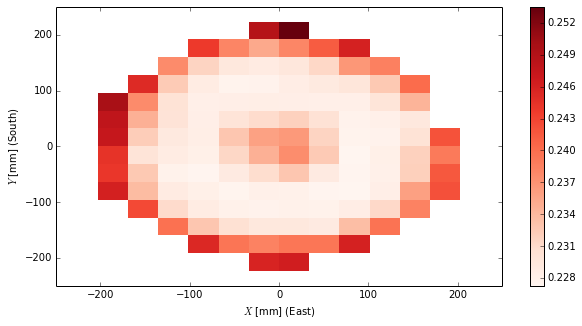

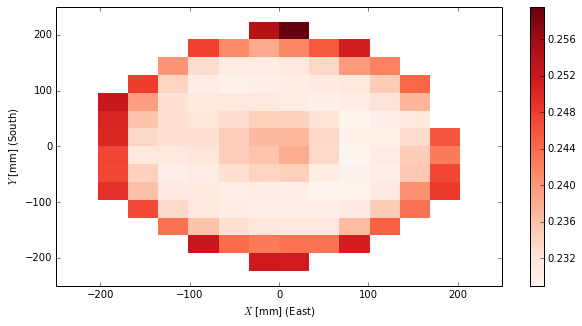

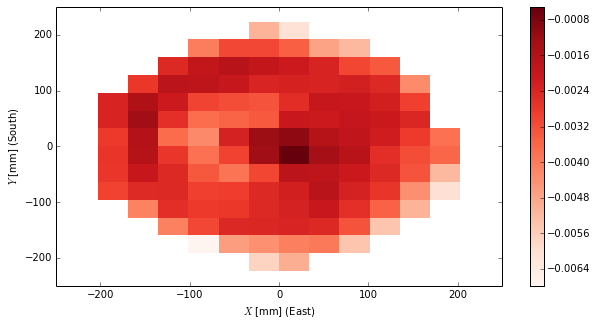

In [235]:
zkey = 'e0'
AWF.plot_field(zkey)
DWF.plot_field(zkey)
DiffWF.plot_field(zkey)

(<matplotlib.figure.Figure at 0x1633bffd0>,
 <matplotlib.axes.AxesSubplot at 0x20efb5350>)

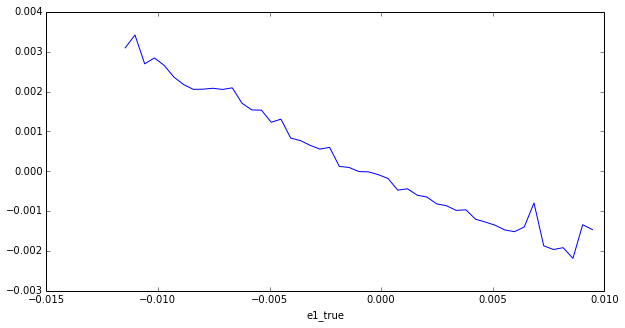

In [292]:
DWF.plot_hist(Diffdf, 'e1_true', 'e1', num_bins=50)

[-0.11747224  0.02488658]


(<matplotlib.figure.Figure at 0x18c72c710>,
 <matplotlib.axes.AxesSubplot at 0x18cb892d0>)

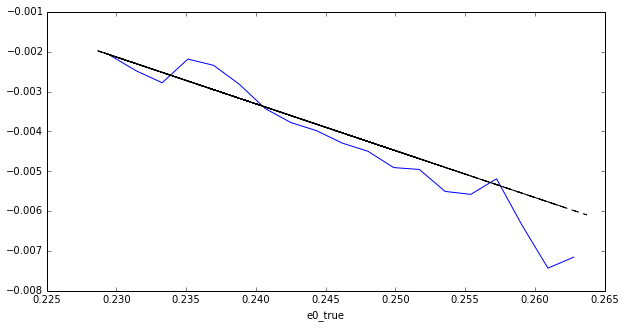

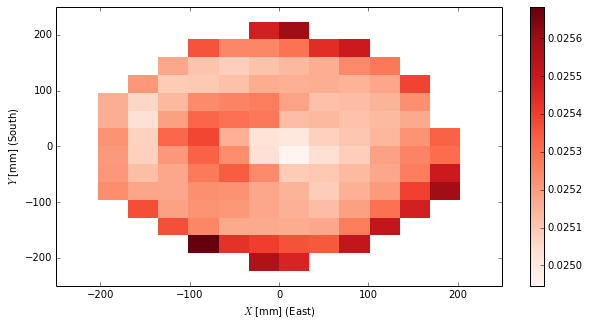

In [314]:
data = Diffdf

key = 'e0'
xkey = '{0}_true'.format(key)
zkey = key
num_bins = 20

bins = np.linspace(np.min(data[xkey]), np.max(data[xkey]), num_bins)
centers = 0.5 * (bins[1:] + bins[:-1])
groups = data.groupby(pd.cut(data[xkey], bins))
agg = groups.aggregate(np.median)

# X, Y = centers, agg[zkey]
X = data[xkey]
Y = data[zkey]
poly = np.polyfit(X, Y, 1)
print(poly)

fig, ax = DWF.plot_hist(Diffdf, '{0}_true'.format(key), key, num_bins=20)
ax.plot(X, np.polyval(poly, X), 'k--')

DiffWF.field[zkey] = np.polyval(poly, DiffWF.field[zkey] )
DiffWF.plot_field(zkey)

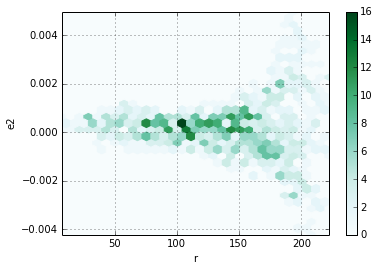

In [259]:
Diffdf['r'] = np.sqrt(Diffdf['x'] ** 2 + Diffdf['y'] ** 2)
key = 'e2'
Diffdf.plot(x='r', y=key, kind='hexbin', gridsize=30)

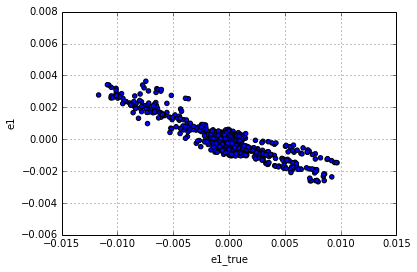

In [250]:
key = 'e1'
Diffdf.plot(x='{0}_true'.format(key), y=key, kind='scatter')